This notebook uses our own EEG library to reproduce the N400 effect in the naturalistic dataset of Frank et al. 2015.
It compares with the epoched ERP output produced by `Frank N400 sanity check.ipynb`.
The output is used in the Rmd notebook corresponding to this file for a regression analysis.

In [123]:
from pathlib import Path

import mne
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

basedir = Path("..").resolve()
import sys
sys.path.append(str(basedir))

DATA_DIR = Path("/om/data/public/language-eeg/frank2015")

EPOCH_WINDOW = (-0.1, 0.924)
TEST_WINDOW = (0.3, 0.5)
# Band-pass filter parameters

N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]

In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
from mfn400.adapters.frank2015 import FrankDatasetAdapter
from mfn400.n400 import prepare_erp_df

In [118]:
data = FrankDatasetAdapter(DATA_DIR, basedir / "output/frank2015/stim_df.csv")

In [119]:
epochs = data.to_erp(EPOCH_WINDOW)

Used Annotations descriptions: ['10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '23

In [122]:
erp_df = pd.concat([prepare_erp_df(epochs[subject], data.get_presentation_data(subject), test_window=TEST_WINDOW)
                    for subject in tqdm(epochs)],
                   names=["subject_idx"], keys=[int(idx) for idx in epochs.keys()])

# Filter out stimuli of .. unknown origin.
erp_df = erp_df.loc[erp_df.sentence_idx != -1]
erp_df

index  onset_time  word_idx  sentence_idx       word  \
subject_idx                                                              
1           0         1       9.824         0           105         He   
            1         2      10.496         1           105     heaved   
            2         3      11.236         2           105        his   
            3         4      11.924         3           105  shoulders   
            4         5      12.720         4           105        and   
...                 ...         ...       ...           ...        ...   
24          1926   2131    1991.376         1             4      don't   
            1927   2132    1992.104         2             4       want   
            1928   2133    1992.804         3             4         to   
            1929   2134    1993.476         4             4       hear   
            1930   2135    1994.172         5             4        it.   

                  surprisal  word_len  item condition  epoch  ...         29  \
subject_idx                                                   ...              
1           0     13.537790       2.0   105       155      0  ...   6.451695   
            1      4.371796       6.0   105         2      1  ...  -5.950469   
            2      2.634916       3.0   105         3      2  ...  -0.018028   
            3      0.082493       9.0   105         4      3  ...  -3.947637   
            4      3.950555       3.0   105         5      4  ...  13.661688   
...                     ...       ...   ...       ...    ...  ...        ...   
24          1926   3.830239       5.0     4         2   1926  ...   1.801485   
            1927   5.037700       4.0     4         3   1927  ...   4.031232   
            1928   1.203626       2.0     4         4   1928  ...   3.187580   
            1929   4.765618       4.0     4         5   1929  ... -10.788127   
            1930   2.480149       3.0     4         6   1930  ...   4.512518   

                         26         18         10         16         12  \
subject_idx                                                               
1           0      8.473479  -0.953125   3.516908  -6.707670   1.457305   
            1     -2.671243  -4.819425   0.542421 -14.050796  -6.547495   
            2     -1.068963  -1.618497   4.156732  -6.302194  -1.848561   
            3     -4.316385  -4.055234  -3.389210  -8.968672  -6.364237   
            4     18.523011   3.415437   9.698321   7.279470  16.007086   
...                     ...        ...        ...        ...        ...   
24          1926   0.528591  11.250285  15.679635   4.047715   9.798944   
            1927  -0.525114   7.472888  11.770855   4.416311   2.967803   
            1928   1.469102  -0.683634  -0.946463   1.225486   0.557334   
            1929 -15.246214  -7.790870  -5.596820 -12.667772 -16.254395   
            1930  10.958129  11.636491  21.862943   4.463291  13.858808   

                         14          1         35          8  
subject_idx                                                   
1           0      6.162977  -6.865402  18.173104   4.912301  
            1     -6.469285 -11.272670  16.499382   0.683365  
            2      0.106752  -3.236988  14.747793   4.889277  
            3     -5.849335  -9.281150   9.090665  -4.391510  
            4     15.302116  10.262801   9.400831   3.405278  
...                     ...        ...        ...        ...  
24          1926   0.647372  13.767632   1.052274   9.612214  
            1927  -2.578065   3.039282  20.059366  14.438944  
            1928   1.486872  -0.155983   3.212761   1.170154  
            1929 -17.908023  -6.826666   2.281942  -0.217220  
            1930  14.731881  27.048473  10.391945  30.286080  

[45715 rows x 44 columns]

---

## Sanity check

Compare with N400 values from epoched data in Frank dataset (converted to our format in the notebook "Frank N400 sanity check.ipynb" in this repo).

In [124]:
import seaborn as sns

In [125]:
reference_df = pd.read_csv(basedir / "output/frank_erp_n400.csv", index_col=["subject_idx", "sentence_idx", "word_idx"])
reference_df = reference_df

In [126]:
our_erp_df = erp_df.copy()
# Average over N400 electrodes as given in paper.
our_erp_df = our_erp_df.reset_index().set_index(["subject_idx", "sentence_idx", "word_idx"]) \
    .loc[:, N400_ELECTRODES].mean(axis=1).rename("our_N400")
our_erp_df.head()

subject_idx  sentence_idx  word_idx
1            105           0            5.553210
                           1           -3.242207
                           2           -0.209140
                           3           -2.622206
                           4           13.702031
Name: our_N400, dtype: float64

In [127]:
reference_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  \
subject_idx sentence_idx word_idx                                     
1           1            0                3.145689         3.121044   
                         1                8.214565         7.030273   
                         2                8.330564         6.914139   
                         3                3.210452         2.787990   
                         4                8.541803         8.242652   
...                                            ...              ...   
24          205          7                3.924689         3.901125   
                         8                7.945024         6.722867   
                         9                9.959173         8.835783   
                         10               3.884360         3.874658   
                         11               8.574935         8.116138   

                                   surp_rnn_size_4  surp_rnn_size_5  \
subject_idx sentence_idx word_idx                           

In [128]:
# Double-check indexing.
for level in ["subject_idx", "sentence_idx"]:
    assert set(reference_df.index.get_level_values(level)) == set(our_erp_df.index.get_level_values(level)), level

In [130]:
comp_df = pd.merge(reference_df, our_erp_df, left_index=True, right_index=True)
comp_df

value_N400  base_N400  artefact  reject  \
subject_idx sentence_idx word_idx                                            
1           1            0          -4.587560  -4.639654         0       1   
                         1          -1.859916  -2.745968         0       1   
                         2          -0.326976  -0.486989         0       0   
                         3           3.984934   1.054487         0       0   
                         4           6.883699   2.721698         0       1   
...                                       ...        ...       ...     ...   
24          205          7          -2.024615  -4.434225         0       0   
                         8           4.551344   1.269528         0       0   
                         9           4.102198  -2.200850         0       0   
                         10         -2.131469   5.741549         0       0   
                         11         -2.946562  -0.460462         0       1   

                                   surp_ngram_order_2  surp_ngram_order_3  \
subject_idx sentence_idx word_idx                                           
1           1            0                   3.044363            3.044340   
                         1                   5.447571            5.298179   
                         2                   4.487278            3.561708   
                         3                   1.639671            1.415385   
                         4                   7.144369            4.562181   
...                                               ...                 ...   
24          205          7                   3.851212            4.149281   
                         8                   4.030146            4.339636   
                         9                   6.416153            6.987241   
                         10                  3.648262            2.545669   
                         11                  5.210036            1.392226   

                                   surp_ngram_order_4  surp_rnn_size_1  \
subject_idx sentence_idx word_idx                                        
1           1            0                   3.044340         3.482672   
                         1                   5.292745         9.514440   
                         2                   3.084290         9.111075   
                         3                   0.676790         3.594287   
                         4                   4.629370         8.459698   
...                                               ...              ...   
24          205          7                   4.245483         4.631127   
                         8                   4.272032         8.139806   
                         9                   6.910058        10.800107   
                         10                  2.342811         4.568191   
                         11                  1.327797         9.073960   

                                   surp_rnn_size_2  surp_rnn_size_3  \
subject_idx sentence_idx word_idx                                     
1           1            0                3.145689         3.121044   
                         1                8.214565         7.030273   
                         2                8.330564         6.914139   
                         3                3.210452         2.787990   
                         4                8.541803         8.242652   
...                                            ...              ...   
24          205          7                3.924689         3.901125   
                         8                7.945024         6.722867   
                         9                9.959173         8.835783   
                         10               3.884360         3.874658   
                         11               8.574935         8.116138   

                                   surp_rnn_size_4  surp_rnn_size_5  \
subject_idx sentence_idx word_idx                           

<AxesSubplot:xlabel='value_N400', ylabel='our_N400'>

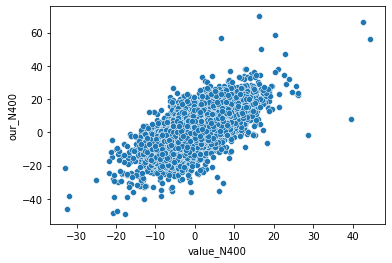

In [132]:
sns.scatterplot(data=comp_df.reset_index(), x="value_N400", y="our_N400")

## Output for R regression

In [ ]:
# For regression we'll include the control values from other Frank setup as well.
# But merge back in our data.
regression_df = pd.merge(comp_df, erp_

In [74]:
comp_df.to_csv(basedir / "output/frank_erp_n400-repro.csv")

---

In [35]:
import mne

In [36]:
m2 = mne.io.read_raw_eeglab("/om/data/public/language-eeg/frank2015/EEG02.set", preload=True)
m1 = mne.io.read_raw_eeglab("/om/data/public/language-eeg/frank2015/EEG01.set", preload=True)

# NB EEG data recorded during sentence boundaries is marked as NaN in the raw data. this is awkward. maybe best to split data at NaN boundaries, then rebuild with `concatenate_raw` (so boundaries don't get messed up during epoching)

KeyboardInterrupt: 

In [ ]:
print(sorted(m1.ch_names))

In [ ]:
montage = mne.channels.make_standard_montage("easycap-M10")

In [ ]:
montage.plot()

In [ ]:
m1.info["highpass"] = 0.25

In [ ]:
m1_mat = m1.get_data()

In [ ]:
import numpy as np

# Get indices into raw EEG data where stimulus presentation begins
# (i.e. index i s.t. data[i] is not NaN and data[i - 1] is NaN)
presentation_begins = np.where(~np.isnan(m1_mat[0, 1:]) & np.isnan(m1_mat[0, :-1]))[0]
presentation_ends = np.where(~np.isnan(m1_mat[0, :-1]) & np.isnan(m1_mat[0, 1:]))[0]
presentation_spans = np.array(list(zip(presentation_begins, presentation_ends)))
presentation_spans

In [ ]:
# Sanity check: no overlapping spans.
assert not (presentation_spans[:-1, 1] > presentation_spans[1:, 0]).any()

In [ ]:
m1.n_times

In [ ]:
np.concatenate([m1_mat[:, begin:end] for begin, end in presentation_spans], axis=1).shape

In [ ]:
m1_mat[:, presentation_spans].shape

In [ ]:
m1.info["sfreq"]

In [ ]:
m1.annotations.onset

In [ ]:
m1_events, m1_event_id = mne.events_from_annotations(m1)
m1_epochs = mne.Epochs(m1, events=m1_events, event_id=m1_event_id, preload=True)
m1_epochs.average().plot()

In [ ]:
import pandas as pd
s1 = pd.Series(['a', 'b'])
s2 = pd.Series(['c', 'd'])
pd.concat([s1, s2], keys=["s1", "s2"], names=["abc", "def"])

In [ ]:
import scipy.io

In [ ]:
stim_data = scipy.io.loadmat("/om/data/public/language-eeg/frank2015/stimuli_erp.mat", simplify_cells=True)

In [ ]:
stim_df = pd.concat([pd.DataFrame({"word": sent}) for sent in stim_data["sentences"]],
                    keys=np.arange(len(stim_data["sentences"])) + 1, names=["sentence_idx", "word_idx"])
stim_df

In [ ]:
annotations_df = pd.DataFrame({"description": m1.annotations.description.astype(int), "onset": m1.annotations.onset})

In [ ]:
annotations_df.loc[annotations_df.description <= 50, "word_idx"] = annotations_df.description - 1
annotations_df.loc[annotations_df.description > 50, "word_idx"] = 0
annotations_df.loc[annotations_df.description > 50, "sentence_idx"] = annotations_df.description - 50
annotations_df["sentence_idx"] = annotations_df.sentence_idx.fillna(method="ffill")
annotations_df = annotations_df.astype({"word_idx": int, "sentence_idx": int}).drop(columns=["description"])
annotations_df.head(50)

In [ ]:
merged_df = pd.merge(annotations_df, stim_df, left_on=["sentence_idx", "word_idx"], right_index=True)
merged_df